In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py
import hdf5storage
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from PIL import Image
from matplotlib.image import imread
import os
from tensorflow.keras import applications

In [2]:
PATH_TO_TRAIN = '/home/maxim/Desktop/ml_dataset/dogs-cats/train_imgs'
PATH_TO_TEST = '/home/maxim/Desktop/ml_dataset/dogs-cats/test_imgs'

In [3]:
def show_random_imgs(path_to):    
    fig = plt.figure(figsize = (15, 15))
    for i in range(1, 4):
        image_path = path_to + str(random.randrange(0, 12499)) + '.jpg'
        image = imread(image_path)
        plot = fig.add_subplot(2,4,i)
        plot.imshow(image)
    plt.show()
    plt.close()

Отобразим несколько изображений котов.

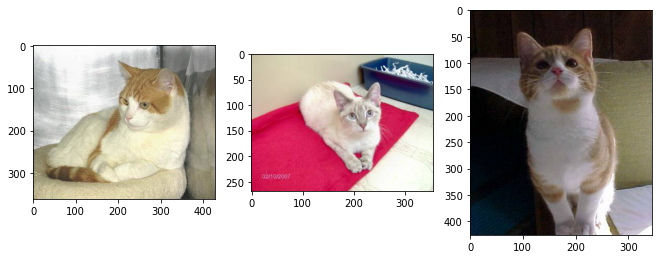

In [4]:
show_random_imgs('/home/maxim/Desktop/ml_dataset/dogs-cats/train_imgs/cats/cat.')

Отобразим несколько изображений собак.

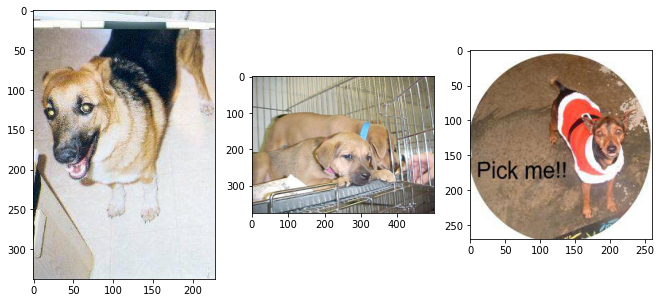

In [5]:
show_random_imgs('/home/maxim/Desktop/ml_dataset/dogs-cats/train_imgs/dogs/dog.')

Определим flow обычных изображений при помощи ImageDataGenerator, которые будут использоваться для обучения сети.

In [6]:
# DEFINE CLASSIC SETS

VALIDATION_SET_RATE = 0.03
BATCH_SIZE = 128
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
EPOCHS_COUNT = 5

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

train_data_gen = image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='training',
                                                     class_mode='binary')
STEPS_PER_EPOCH_TRAIN = np.ceil(train_data_gen.samples/BATCH_SIZE)

validation_data_gen = image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='validation',
                                                     class_mode='binary')

STEPS_PER_EPOCH_VALIDATION = np.ceil(validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


Определим augumented изображения. Для этого будем использовать параметры ImageDataGenerator'a, такие как width_shift_range, height_shift_range и horizontal_flip.

In [7]:
# DEFINE AUGUMENTED SETS

augumented_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    validation_split=VALIDATION_SET_RATE
)

au_train_data_gen = augumented_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='training',
                                                     class_mode='binary')
AU_STEPS_PER_EPOCH_TRAIN = np.ceil(au_train_data_gen.samples/BATCH_SIZE)

au_validation_data_gen = augumented_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='validation',
                                                     class_mode='binary')

AU_STEPS_PER_EPOCH_VALIDATION = np.ceil(au_validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


Далее определим нашу первую модель - 3 связки свёртка-пулинг + полносвязные слои.

In [8]:
# DEFINE THE MODEL

input_layer = layers.Input(shape=((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
conv_1 = layers.Conv2D(16, kernel_size=(3, 3), padding='valid')
conv_2 = layers.Conv2D(32, kernel_size=(3, 3), padding='valid')
conv_3 = layers.Conv2D(64, kernel_size=(3, 3), padding='valid')
mp_1 = layers.MaxPooling2D(strides=(2, 2))
mp_2 = layers.MaxPooling2D(strides=(2, 2))
mp_3 = layers.MaxPooling2D(strides=(2, 2))

fc_1 = layers.Dense(128, activation='relu')
fc_2 = layers.Dense(64, activation='relu')

out_layer = layers.Dense(1, activation='sigmoid')

model = keras.Sequential([
        input_layer,
        conv_1,
        mp_1,
        conv_2,
        mp_2,
        conv_3,
        mp_3,
        layers.Flatten(),
        fc_1,
        fc_2,
        out_layer
    ])
model.summary()

model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Для ускорения отладки будем использовать сохранение моделей.

In [9]:
keras.backend.clear_session()

if os.path.exists('three_conv.h5'):
    model = load_model('three_conv.h5')
else:
    history = model.fit_generator(
        train_data_gen,
        validation_data=validation_data_gen,
        steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        epochs=EPOCHS_COUNT,
        verbose=1
    )
    model.save('three_conv.h5')

Следующей определим модель, которая будет использовать аугументированные данные, по структуре она повторяет предыдущую - 3 связки свёртка-пулинг, 2 полносвязных слоя.

In [10]:
au_input_layer = layers.Input(shape=((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
au_conv_1 = layers.Conv2D(16, kernel_size=(3, 3), padding='valid')
au_conv_2 = layers.Conv2D(32, kernel_size=(3, 3), padding='valid')
au_conv_3 = layers.Conv2D(64, kernel_size=(3, 3), padding='valid')
au_mp_1 = layers.MaxPooling2D(strides=(2, 2))
au_mp_2 = layers.MaxPooling2D(strides=(2, 2))
au_mp_3 = layers.MaxPooling2D(strides=(2, 2))

au_fc_1 = layers.Dense(128, activation='relu')
au_fc_2 = layers.Dense(64, activation='relu')

au_out_layer = layers.Dense(1, activation='sigmoid')

au_model = keras.Sequential([
        au_input_layer,
        au_conv_1,
        au_mp_1,
        au_conv_2,
        au_mp_2,
        au_conv_3,
        au_mp_3,
        layers.Flatten(),
        au_fc_1,
        au_fc_2,
        au_out_layer
    ])
au_model.summary()

au_model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Так же будем использовать сохранение моделей для более быстрой отладки.

In [11]:
if os.path.exists('three_conv_au.h5'):
    au_model = load_model('three_conv_au.h5')
else:
    au_history = au_model.fit_generator(
        au_train_data_gen,
        validation_data=au_validation_data_gen,
        steps_per_epoch=AU_STEPS_PER_EPOCH_TRAIN,
        validation_steps=AU_STEPS_PER_EPOCH_VALIDATION,
        epochs=EPOCHS_COUNT,
        verbose=1
    )
    au_model.save('three_conv_au.h5')

Проверим работу полученных моделей.

In [12]:
# On classic 3-conv
model.evaluate(validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 2s 314ms/step - loss: 0.5976 - accuracy: 0.6693


[0.5975512067476908, 0.66933334]

Модель с 3мя парами свёртки-пулинга показала 66% процентную точность.

In [13]:
# On augumented 3-conv
au_model.evaluate(validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 2s 282ms/step - loss: 0.6352 - accuracy: 0.6013


[0.6351641019185384, 0.6013333]

Такая же модель, но уже с аугументированными данными показала себя чуть хуже, однако точность 60%.

Далее определим модель VGG-16 и data flows для неё.

In [14]:
# VGG-16
keras.backend.clear_session()
    
vgg16 = applications.VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
        
x = layers.Flatten()(vgg16.layers[-1].output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)
    
vgg16 = keras.Model(inputs=vgg16.inputs, outputs=output)
vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

vgg_train_data_gen = vgg_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='training',
                                                     class_mode='binary')
VGG_STEPS_PER_EPOCH_TRAIN = np.ceil(vgg_train_data_gen.samples/BATCH_SIZE)

vgg_validation_data_gen = vgg_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='validation',
                                                     class_mode='binary')

VGG_STEPS_PER_EPOCH_VALIDATION = np.ceil(vgg_validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [15]:
if os.path.exists('vgg16.h5'):
    vgg16 = load_model('vgg16.h5')
else:
    vgg_history = vgg16.fit_generator(
        vgg_train_data_gen,
        validation_data=vgg_validation_data_gen,
        steps_per_epoch=VGG_STEPS_PER_EPOCH_TRAIN,
        validation_steps=VGG_STEPS_PER_EPOCH_VALIDATION,
        epochs=1,
        verbose=1
    )
    vgg16.save('vgg16.h5')

In [16]:
# On VGG-16
vgg16.evaluate(vgg_validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 185s 31s/step - loss: 0.1878 - accuracy: 0.9267


[0.18779834608236948, 0.9266667]

Как видно из результатов, модель VGG-16 показала лучший на данный момент результат точность - 92%. Однако стоит также отметить, что на одну эпоху обучения данной модели уходит порядка 1 часа времени.

Далее определим модель Resnet.

In [17]:
# RESNET
keras.backend.clear_session()
    
resnet = applications.resnet.ResNet50(include_top=False, input_shape=(224, 224, 3))
for layer in resnet.layers:
    layer.trainable = False
        
x1 = layers.Flatten()(resnet.layers[-1].output)
x1 = layers.Dense(128, activation='relu')(x1)
output1 = layers.Dense(1, activation='sigmoid')(x1)
    
resnet = keras.Model(inputs=resnet.inputs, outputs=output1)
resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

resnet_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

resnet_train_data_gen = resnet_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='training',
                                                     class_mode='binary')
RESNET_STEPS_PER_EPOCH_TRAIN = np.ceil(resnet_train_data_gen.samples/BATCH_SIZE)

resnet_validation_data_gen = resnet_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='validation',
                                                     class_mode='binary')

RESNET_STEPS_PER_EPOCH_VALIDATION = np.ceil(resnet_validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [18]:
if os.path.exists('resnet.h5'):
    resnet = load_model('resnet.h5')
else:
    resnet_history = resnet.fit_generator(
        resnet_train_data_gen,
        validation_data=resnet_validation_data_gen,
        steps_per_epoch=RESNET_STEPS_PER_EPOCH_TRAIN,
        validation_steps=RESNET_STEPS_PER_EPOCH_VALIDATION,
        epochs=1,
        verbose=1
    )
    resnet.save('resnet.h5')

In [19]:
# On RESNET
resnet.evaluate(resnet_validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 63s 10s/step - loss: 0.7737 - accuracy: 0.5013


[0.7736942768096924, 0.50133336]

Как видно, данная модель показала не самый лучший результат, однако, данный результат, можно предположить, был получен из за малого количества эпох.

Если рассматривать вышеописанные модели, можно отметить, что лучший результат показала модель VGG-16, но и время обучения такой модели очень велико - порядка 1 часа на эпоху, что в перспективе, может занять очень много времени на обучение.

На сайте Kaggle, лучший результат полученный на данном датасете является 98%. Можно предположить, что что-то приближенное можно получить на модели VGG-16, если применить множество методов улучшения результата, использовать augumented data на данной модели, например.